In [1]:
import torch
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4090 Laptop GPU


In [3]:
import pandas as pd

df = pd.read_csv("./in_domain_train.csv", delimiter=',')

print('Количество предложений: {:,}\n'.format(df.shape[0]))

df.sample(10)
df

Количество предложений: 7,869



,id,sentence,acceptable,error_type,detailed_source
0,0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010
...,...,...,...,...,...
7864,7864,Установки не было введено в действие.,0,Semantics,Paducheva2004
7865,7865,"Конечно, против такой системы ценностей решите...",0,Semantics,Paducheva2013
7866,7866,Симптомов болезни не исчезло.,0,Semantics,Paducheva2013
7867,7867,Послезавтра температура у больного снижается д...,0,Semantics,Rusgram


In [9]:
df.loc[df.acceptable == 0].sample(5)[['sentence', 'acceptable']]

,sentence,acceptable
5888,"Если такой материал уже имеется, то сможете ли...",0
7734,Она воздержалась от всяких комментариев.,0
4591,"Те, кто читал критическую статью Н. А.Добролюб...",0
1997,У воды есть кислород.,0
5925,Арбитражный суд согласился под этим выводом.,0


In [10]:
sentences = df.sentence.values
labels = df.acceptable.values

In [17]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('ai-forever/ruBert-large', do_lower_case=True)

In [18]:
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Tokenized:  ['вдруг', 'решетка', 'беззвучно', 'поехала', 'в', 'сторону', ',', 'и', 'на', 'балконе', 'возникла', 'таинственная', 'фигура', ',', 'прячу', '##щаяся', 'от', 'лунного', 'света', ',', 'и', 'погрозил', '##а', 'ива', '##ну', 'пальцем', '.']
Token IDs:  [3014, 83321, 41548, 32350, 113, 2931, 121, 107, 660, 50354, 13779, 99183, 15226, 121, 94376, 19913, 700, 55918, 6412, 121, 107, 95640, 377, 104691, 717, 11420, 126]


In [19]:
max_len = 0

for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  45


In [20]:
import torch
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Вдруг решетка беззвучно поехала в сторону, и на балконе возникла таинственная фигура, прячущаяся от лунного света, и погрозила Ивану пальцем.
Token IDs: tensor([   101,   3014,  83321,  41548,  32350,    113,   2931,    121,    107,
           660,  50354,  13779,  99183,  15226,    121,  94376,  19913,    700,
         55918,   6412,    121,    107,  95640,    377, 104691,    717,  11420,
           126,    102,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])


C:\Users\Руслан\AppData\Local\Temp\ipykernel_23376\2249477459.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [21]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,082 training samples
  787 validation samples


In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [23]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "ai-forever/ruBert-large",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((

In [24]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (120138, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             

In [25]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

In [26]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [27]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [29]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


C:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  Batch    40  of    222.    Elapsed: 0:00:19.
  Batch    80  of    222.    Elapsed: 0:00:34.
  Batch   120  of    222.    Elapsed: 0:00:49.
  Batch   160  of    222.    Elapsed: 0:01:04.
  Batch   200  of    222.    Elapsed: 0:01:19.

  Average training loss: 0.51
  Training epcoh took: 0:01:27

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.48
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:15.
  Batch    80  of    222.    Elapsed: 0:00:30.
  Batch   120  of    222.    Elapsed: 0:00:45.
  Batch   160  of    222.    Elapsed: 0:01:00.
  Batch   200  of    222.    Elapsed: 0:01:15.

  Average training loss: 0.28
  Training epcoh took: 0:01:24

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.55
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    222.    Elapsed: 0:00:15.
  Batch    80  of    222.    Elapsed: 0:00:31.
  Batch   120  of    222.    Elapsed: 0:00:4

In [30]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.510490,0.475384,0.795724,0:01:27,0:00:02
2,0.276571,0.554419,0.781974,0:01:24,0:00:02
3,0.124545,0.738616,0.802829,0:01:24,0:00:02
4,0.056731,0.949572,0.813684,0:01:23,0:00:02


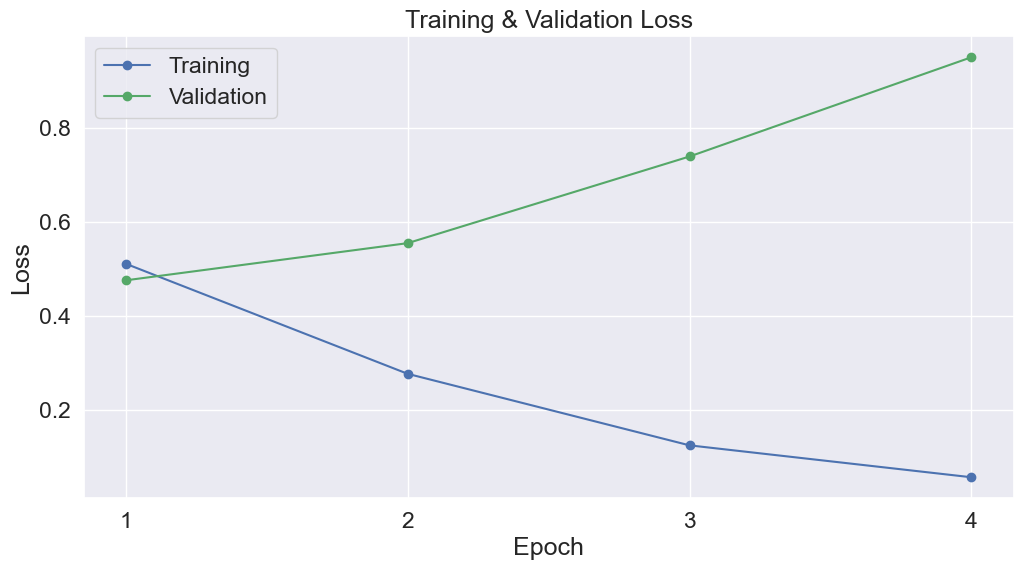

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [32]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./in_domain_dev.csv", delimiter=',')
df.head()

,id,sentence,acceptable,error_type,detailed_source
0,0,Иван вчера не позвонил.,1,0,Paducheva2013
1,1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8
2,2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5
3,3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova
4,4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets


In [33]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.acceptable.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 983



C:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 983 test sentences...
    DONE.


In [36]:
print('Positive samples: %d of %d (%.2f%%)' % (df.acceptable.sum(), len(df.acceptable), (df.acceptable.sum() / len(df.acceptable) * 100.0)))

Positive samples: 733 of 983 (74.57%)


In [37]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [38]:
from sklearn.metrics import matthews_corrcoef
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.383


## RuGPT3 few-/zero-shot

In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")

model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")

In [16]:
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1536)
    (wpe): Embedding(2048, 1536)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1536, out_features=50257, bias=False)
)

In [17]:
import math
def calc_loss(phrase: str,
                        tokenizer,
                        model):

    phrase = tokenizer.encode(phrase)
    # Если длина фразы 1 токен, то дальше ошибка вылезет :(
    if len(phrase) == 1:
         phrase.append(tokenizer.eos_token_id)
    phrase = torch.tensor(phrase, dtype=torch.long, device=device)
    phrase = phrase.unsqueeze(0)  # .repeat(num_samples, 1)
    with torch.no_grad():
        loss = model(phrase, labels=phrase)

    loss[0].item()


    return loss[0].item()

def get_loss_num(text):
    loss = calc_loss(phrase=text, model=model, tokenizer=tokenizer)
    return loss

def clean(text):
    text = re.sub(r'\((\d+)\)', '', text)
    return text


### Zero-shot


In [106]:
sentences[10]

'Не думаю, что мосты уже сняли.'

In [10]:
labels[10]

1

In [48]:
import random
promts_zero = [
    (f'Эта фраза грамматически корректна?', f'Эта фраза грамматически не верна?'),
    (f'Грамматически верное предложение?', f'Грамматически не верное предложение?'),
    (f'Грамматически верное предложение', f'Грамматически не верное предложение'),
    (f'Верно?', f'Не верно?')
]
rate_promt = {}
sample_size = 1000
for p in promts_zero:
    correct = p[0]
    in_correct = p[1]
    rate_promt[f'{correct}, {in_correct}'] = 0
    for i in random.sample(range(len(sentences)), sample_size):
        estimate = get_loss_num(f'{correct} {sentences[i]}') < get_loss_num(f'{in_correct} {sentences[i]}')
        if estimate == labels[i]:
            rate_promt[f'{correct}, {in_correct}'] =  rate_promt[f'{correct}, {in_correct}'] + 1
sorted_prompts = list(sorted(rate_promt.items(), key=lambda item: item[1], reverse=True))



Лучшая затравка: Верно?, Не верно? - 698/1000


#### Рейтинг затравок

In [53]:
for prompt in sorted_prompts:
    print(f'"{prompt[0]}", {prompt[1]}/{sample_size}')

"Верно?, Не верно?", 698/1000
"Грамматически верное предложение?, Грамматически не верное предложение?", 492/1000
"Грамматически верное предложение, Грамматически не верное предложение", 359/1000
"Эта фраза грамматически корректна?, Эта фраза грамматически не верна?", 273/1000


### Few-shot

In [18]:
 # Готовим примеры
import random
def get_few_shots_examples(num_examples):
    few_shots = []
    examples = ''
    yOrN = {
        0: 'Нет',
        1: 'Да'
    }
    for i in range (num_examples):
        k = random.randint(0, 1)
        sentence = df.loc[df.acceptable == k].sample(1)[['sentence']].sentence.values[0]
        few_shots.append(f'Предложение далее корректное? {sentence}  Ответ: {yOrN.get(labels[k])}.')
    return '\n'.join(few_shots)

In [24]:
rate_promt = {}

In [33]:
def estimate_few_shot(sample_size, num_examples):
    examples = get_few_shots_examples(num_examples)
    rate_promt[num_examples] = 0
    for i in random.sample(range(len(sentences)), sample_size):
        estimate = get_loss_num(f'{examples} Предложение далее корректное?  {sentences[i]} Ответ: да.') < get_loss_num(f'{examples} Предложение далее корректное?  {sentences[i]} Ответ: нет.')       
        if estimate == labels[i]:
            rate_promt[num_examples] =  rate_promt[num_examples] + 1
    return rate_promt

In [34]:
sample_size = 30
num_examples = 4
estimate_few_shot(sample_size, num_examples)
print(f'Количество затравок: {num_examples}, число верных ответов: {rate_promt.get(num_examples)}/{sample_size}')

Количество затравок: 4, число верных ответов: 13/30


In [35]:
sample_size = 30
num_examples = 3
estimate_few_shot(sample_size, num_examples)
print(f'Количество затравок: {num_examples}, число верных ответов: {rate_promt.get(num_examples)}/{sample_size}')

Количество затравок: 3, число верных ответов: 11/30


In [36]:
sample_size = 30
num_examples = 2
estimate_few_shot(sample_size, num_examples)
print(f'Количество затравок: {num_examples}, число верных ответов: {rate_promt.get(num_examples)}/{sample_size}')

Количество затравок: 2, число верных ответов: 20/30


In [37]:
sample_size = 30
num_examples = 1
estimate_few_shot(sample_size, num_examples)
print(f'Количество затравок: {num_examples}, число верных ответов: {rate_promt.get(num_examples)}/{sample_size}')

Количество затравок: 1, число верных ответов: 19/30


In [38]:
sample_size = 30
num_examples = 0
estimate_few_shot(sample_size, num_examples)
print(f'Количество затравок: {num_examples}, число верных ответов: {rate_promt.get(num_examples)}/{sample_size}')

Количество затравок: 0, число верных ответов: 14/30


In [46]:
from transformers import T5ForConditionalGeneration,T5Tokenizer
model=T5ForConditionalGeneration.from_pretrained('sberbank-ai/ruT5-large')
tokenizer=T5Tokenizer.from_pretrained('sberbank-ai/ruT5-large')

OSError: Unable to load vocabulary from file. Please check that the provided vocabulary is accessible and not corrupted.